### 3.4.1 导入模块并指定模型输入维度

In [15]:
import matplotlib.pyplot as plt
import numpy as np

from keras.datasets import mnist
from keras.layers import Dense, Flatten, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential
from keras.optimizers import Adam

In [16]:
# 指定模型和数据集的输入维度
img_rows = 28
img_cols = 28
channels = 1

# 输入图片维度
img_shape = (img_rows, img_cols, channels)

# 噪声向量的大小用作生成器的输入
z_dim = 100

### 3.4.2 构造生成器

In [17]:
def build_generator(img_shape, z_dim):
    model = Sequential()

    # 全连接层
    model.add(Dense(128, input_dim=z_dim))

    # LeakyReLU激活函数
    model.add(LeakyReLU(alpha=0.01))

    # 带tanh函数的输出层
    model.add(Dense(28 * 28 * 1, activation='tanh'))

    # 生成器的输出改变为图像尺寸
    model.add(Reshape(img_shape))

    return model

### 3.4.3 构造鉴别器

In [18]:
def build_discriminator(img_shape):
    model = Sequential()

    # 输入图像展平
    model.add(Flatten(input_shape=img_shape))

    # 全连接层
    model.add(Dense(128))
    
    # LeakyReLU激活函数
    model.add(LeakyReLU(alpha=0.01))

    # 带sigmoid函数的输出层
    model.add(Dense(1, activation='sigmoid'))

    return model

### 3.4.4 搭建整个模型

In [19]:
# 构建并编译GAN
def build_gan(generator, discriminator):
    model = Sequential()

    # 生成器模型与鉴别器模型结合在一起
    model.add(generator)
    model.add(discriminator)

    return model

In [20]:
# 构建并编译鉴别器
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                                            optimizer=Adam(),
                                            metrics=['accuracy'])

# 构建生成器
generator = build_generator(img_shape, z_dim)

# 训练生成器时保持鉴别器的参数固定
discriminator.trainable = False

# 构建并编译鉴别器固定的GAN模型，以训练生成器
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

### 3.4.5 训练

In [21]:
# GAN训练循环
losses = []
accuracies = []
iteration_checkpoints = []

def train(iterations, batch_size, sample_interval):

    # 加载MINST数据集
    (X_train, _), (_, _) = mnist.load_data()

    # 灰度像素值[0, 255]缩放到[−1,1]
    X_train = X_train / 127.5 - 1.0
    X_train = np.expand_dims(X_train, axis=3)

    # 真实图像的标签都是1
    real = np.ones((batch_size, 1))

    # 伪图像的标签是0
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):
        # -------------------------
        #  Train the Discriminator
        # -------------------------

        # 随机噪声采样
        # 获取随机的一批真实图像
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        # 获取随机的一批伪图像
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)
        
        # 训练鉴别器

        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        # ---------------------
        #  Train the Generator
        # ---------------------

        # 生成一批伪图像
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        # 训练生成器
        g_loss = gan.train_on_batch(z, real)

        if(iteration + 1) % sample_interval == 0:

            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)

            # 输出训练过程
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                        (iteration + 1, d_loss, 100.0 * accuracy, g_loss))
            
            # 输出生成图像的采样
            sample_images(generator)

### 3.4.6 输出样本图像

In [22]:
# 显示合成图像
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):

    # 样本随机噪声
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    # 从随机噪声生成图像
    gen_imgs = generator.predict(z)

    # 将图像像素值重缩放至[0, 1]内
    gen_imgs = 0.5 * gen_imgs + 0.5

    # 设置图像网格
    fig, axs = plt.subplots(image_grid_rows, image_grid_columns,
                                                figsize=(4, 4),
                                                sharey=True,
                                                sharex=True)
    
    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # 输出一个图像网格
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1

### 3.4.7 运行模型

1000 [D loss: 0.181977, acc.: 92.19%] [G loss: 3.474745]
2000 [D loss: 0.069473, acc.: 98.44%] [G loss: 4.616875]
3000 [D loss: 0.109225, acc.: 96.48%] [G loss: 4.271446]
4000 [D loss: 0.190620, acc.: 91.80%] [G loss: 4.412727]
5000 [D loss: 0.154018, acc.: 94.92%] [G loss: 4.147542]
6000 [D loss: 0.357477, acc.: 84.77%] [G loss: 4.437704]
7000 [D loss: 0.373295, acc.: 86.33%] [G loss: 4.316839]
8000 [D loss: 0.434252, acc.: 82.81%] [G loss: 4.094031]
9000 [D loss: 0.292164, acc.: 88.67%] [G loss: 3.702960]
10000 [D loss: 0.259317, acc.: 91.02%] [G loss: 3.835668]
11000 [D loss: 0.522221, acc.: 76.95%] [G loss: 3.214907]
12000 [D loss: 0.245719, acc.: 91.02%] [G loss: 3.843093]
13000 [D loss: 0.305297, acc.: 83.98%] [G loss: 3.175481]
14000 [D loss: 0.358196, acc.: 79.69%] [G loss: 3.710468]
15000 [D loss: 0.401353, acc.: 83.20%] [G loss: 2.939919]
16000 [D loss: 0.457978, acc.: 80.47%] [G loss: 2.588091]
17000 [D loss: 0.649507, acc.: 69.92%] [G loss: 2.183342]
18000 [D loss: 0.434951

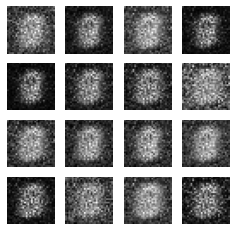

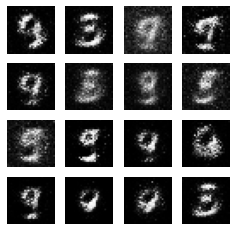

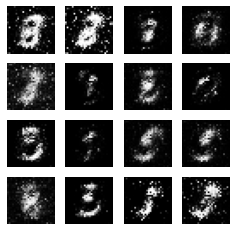

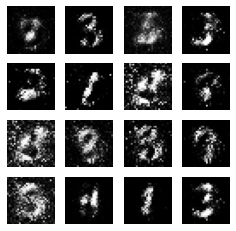

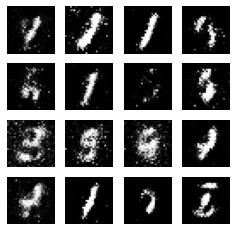

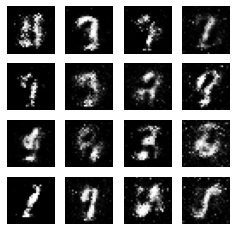

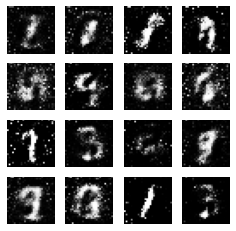

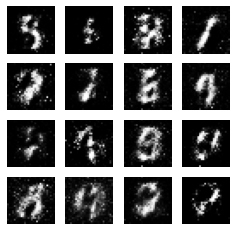

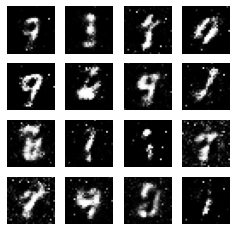

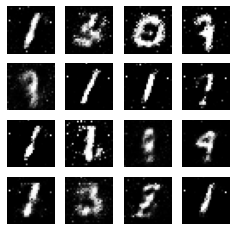

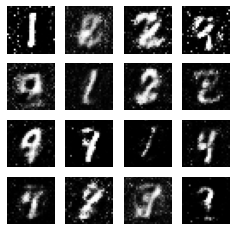

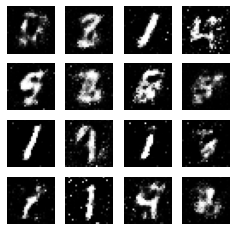

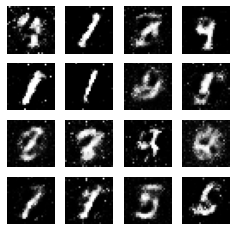

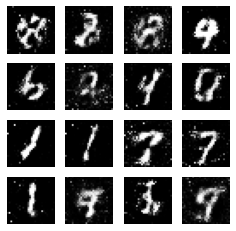

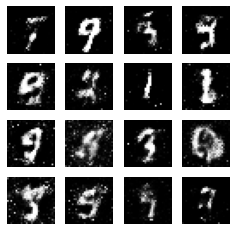

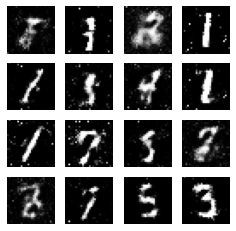

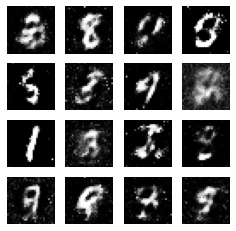

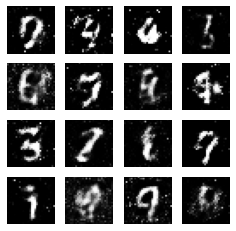

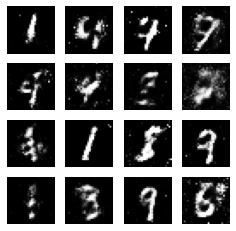

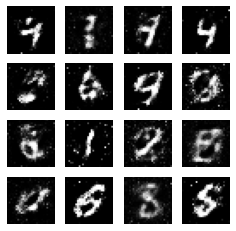

In [23]:
# 设置训练超参数
iterations = 20000
batch_size = 128    # 批量大小
sample_interval = 1000

# 训练GAN直到制定次数
train(iterations, batch_size, sample_interval)

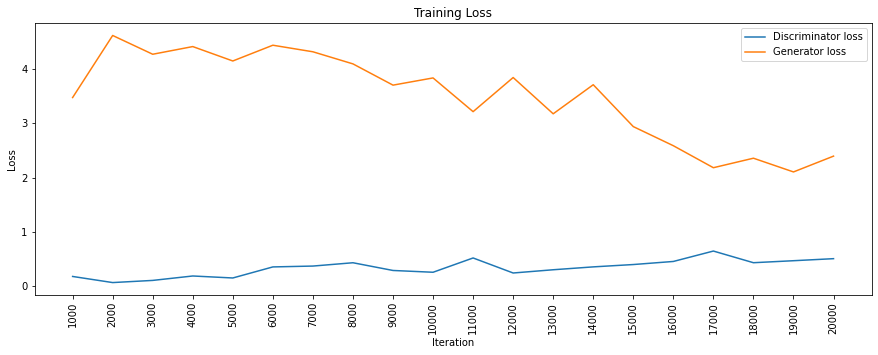

In [25]:
losses = np.array(losses)

# 绘制鉴别器和生成器训练损失
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses.T[0], label="Discriminator loss")
plt.plot(iteration_checkpoints, losses.T[1], label="Generator loss")

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

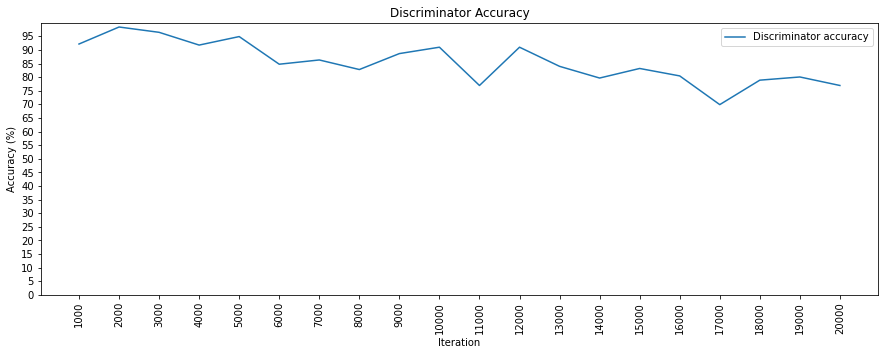

In [26]:
accuracies = np.array(accuracies)

# 绘制鉴别器精确
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, accuracies, label="Discriminator accuracy")

plt.xticks(iteration_checkpoints, rotation=90)
plt.yticks(range(0, 100, 5))

plt.title("Discriminator Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.legend()